# Infer shape
To test the approach, I pass data from one of the three objects trained. First, I try to retrieve the latent vector, and then I try to reconstruct the object.

In [48]:
import numpy as np
import torch
import results
import os
from utils import utils
import plotly.graph_objects as go
import meshplot as mp
import model.sdf_model as sdf_model
from tqdm import tqdm
from utils.utils import SDFLoss_multishape
import trimesh
import skimage
import mesh_to_sdf
import matplotlib.pyplot as plt

Extract pointclouds from one of the objects randomly.

In [49]:
# dictionaries
objs_dict = np.load(os.path.join(os.path.dirname(results.__file__), 'objs_dict.npy'), allow_pickle=True).item()
samples_dict = np.load(os.path.join(os.path.dirname(results.__file__), 'samples_dict.npy'), allow_pickle=True).item()

# list of objects
objs = list(samples_dict.keys())

# select random object
random_obj = objs[np.random.randint(0, len(objs))]

# mesh for random object
mesh = objs_dict[random_obj]

In [50]:
# sample point cloud on random object
num_samples = 5000
samples = utils.mesh_to_pointcloud(mesh['verts'], mesh['faces'], num_samples)

fig = go.Figure(
    [go.Scatter3d(x=samples[:, 0], y=samples[:, 1],z=samples[:, 2], mode='markers',
        marker=dict(
            size=1
            )
    )]
)
fig.show()

Load model:

In [51]:
folder = '21_11_135444'
model = sdf_model.SDFModelMulti(num_layers=8, no_skip_connections=False)

# Load weights
weights_path = os.path.join(os.path.dirname(results.__file__), 'runs', folder, 'weights.pt')
model.load_state_dict(torch.
                      load(weights_path, map_location=torch.device('cpu')))

<All keys matched successfully>

Latent vector learnt during training:

In [52]:
results_dict_path = os.path.join(os.path.dirname(results.__file__), 'runs', folder, 'results.npy')
results_dict = np.load(results_dict_path, allow_pickle=True).item()
latent_1 = torch.from_numpy(results_dict['train']['latent_codes'][-1][0])
latent_2 = torch.from_numpy(results_dict['train']['latent_codes'][-1][1])
latent_3 = torch.from_numpy(results_dict['train']['latent_codes'][-1][2])

model.eval()
grid_values = torch.arange(-1, 1, 0.02) #0.015
grad_size_axis = grid_values.shape[0]
grid = torch.meshgrid(grid_values, grid_values, grid_values)
coords = torch.vstack((grid[0].ravel(), grid[1].ravel(), grid[2].ravel())).transpose(1, 0)

# Latent 1
latent_tile = torch.tile(latent_1, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf_1 = model(coords_latent)
    
# Latent 2
latent_tile = torch.tile(latent_2, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf_2 = model(coords_latent)
    
# Latent 3
latent_tile = torch.tile(latent_3, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf_3 = model(coords_latent)

In [53]:
def extract_mesh(grad_size_axis, sdf):
    grid_sdf = sdf.view(grad_size_axis, grad_size_axis, grad_size_axis).detach().numpy()
    vertices, faces, normals, _ = skimage.measure.marching_cubes(grid_sdf, level=0.00)
    return vertices, faces

vertices, faces = extract_mesh(grad_size_axis, sdf_1)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces, c=vertices[:, 2])

vertices, faces = extract_mesh(grad_size_axis, sdf_2)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces, c=vertices[:, 2])

vertices, faces = extract_mesh(grad_size_axis, sdf_3)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces, c=vertices[:, 2])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.999645…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.967826…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(49.625918…

Infer latent vector:

In [54]:
results_dict['train']['latent_codes'][-1]

array([[ 1.34765100e+00, -7.13006973e-01,  1.49268582e-01,
        -9.03715432e-01,  2.18835250e-01,  3.17884475e-01,
        -5.69079757e-01,  1.37459469e+00,  4.85455930e-01,
        -7.07741380e-02, -2.43893877e-01,  2.06600707e-02,
        -1.27903438e+00, -1.31417596e+00, -1.32804485e-02,
         4.33091611e-01, -2.20467138e+00, -7.64319599e-02,
         8.08334053e-02,  1.39317942e+00, -3.50810051e-01,
        -1.64346576e-01, -1.65562019e-01, -6.84433103e-01,
         5.74376523e-01, -6.37268841e-01,  1.53455555e+00,
         1.71355486e+00, -1.88604459e-01,  6.64711654e-01,
         2.45635062e-01, -1.47141778e+00, -1.14317858e+00,
         6.32330239e-01, -1.31998789e+00,  5.65870166e-01,
         2.08501279e-01,  5.54437101e-01, -2.36576796e+00,
         7.65964687e-01, -1.63047004e+00,  1.17196655e+00,
        -2.75906301e+00,  2.55444109e-01, -6.81985557e-01,
        -6.88676476e-01, -2.29443505e-01,  1.03551447e+00,
         1.07929803e-01,  3.50829989e-01, -2.42793843e-0

(array([ 2.,  3., 15., 35., 66., 80., 94., 47., 34.,  8.]),
 array([-3.2198846 , -2.6712196 , -2.1225545 , -1.5738894 , -1.0252243 ,
        -0.47655928,  0.07210579,  0.6207709 ,  1.169436  ,  1.718101  ,
         2.266766  ], dtype=float32),
 <BarContainer object of 10 artists>)

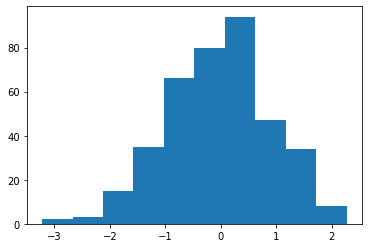

In [55]:
plt.hist(results_dict['train']['latent_codes'][-1].ravel())

In [56]:
folder = '21_11_135444'
model = sdf_model.SDFModelMulti(num_layers=8, no_skip_connections=False)

# Load weights
weights_path = os.path.join(os.path.dirname(results.__file__), 'runs', folder, 'weights.pt')
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

# initialise latent code and optimiser
latent_size = 128
latent_code = torch.mean(torch.from_numpy(results_dict['train']['latent_codes'][-1]), dim=0).view(1, -1)
latent_code.requires_grad = True
#latent_code = torch.normal(0, 0.1, size = (1, latent_size), dtype=torch.float32, requires_grad=True)
optim = torch.optim.Adam([latent_code], lr=0.001)

# initialise training parameters
epochs = 3000
sigma_regulariser = 0.0
lr_multiplier = 0.5
patience = 20
scheduler_latent = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
                                                            factor=lr_multiplier, 
                                                            patience=patience, 
                                                            threshold=0.005, threshold_mode='abs')
loss_values = []


# create dataset
samples_torch = torch.from_numpy(samples)
y = torch.full(size=(samples.shape[0], 1), fill_value=0)

# prediction
for epoch in tqdm(range(0, epochs)):
    latent_code_tile = torch.tile(latent_code, (samples.shape[0], 1))
    x = torch.hstack((latent_code_tile, samples_torch))
    optim.zero_grad()
    predictions = model(x)
    loss_value = SDFLoss_multishape(y, predictions, x[:, :latent_size], sigma=sigma_regulariser)
    loss_value.backward()
    optim.step()
    scheduler_latent.step(loss_value.item())
    loss_values.append(loss_value.detach().item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [15:25<00:00,  3.24it/s]


In [57]:
scheduler_latent._last_lr

[0.001]

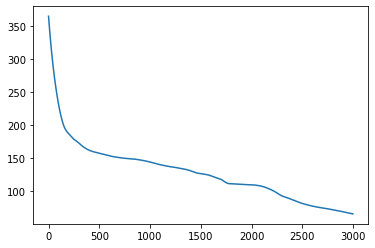

Final loss: 65.67292785644531


In [58]:
plt.plot(loss_values)
plt.show()
print(f'Final loss: {loss_values[-1]}')

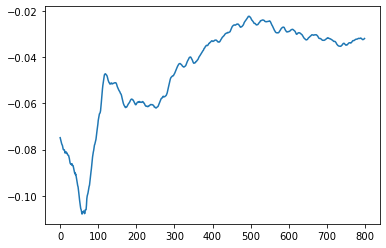

In [59]:
a = (np.array(loss_values[1:]) - np.array(loss_values[:-1]))
plt.plot(a[-800:])
plt.show()

Predict shape:

In [60]:
model.eval()
latent_code.requires_grad = False
grid_values = torch.arange(-1, 1, 0.02) #0.015
grad_size_axis = grid_values.shape[0]
grid = torch.meshgrid(grid_values, grid_values, grid_values)
coords = torch.vstack((grid[0].ravel(), grid[1].ravel(), grid[2].ravel())).transpose(1, 0)
latent_tile = torch.tile(latent_code, (coords.shape[0], 1))
coords_latent = torch.hstack((latent_tile, coords))
with torch.no_grad():
    sdf = model(coords_latent)

Render shape using marching cubes:

In [61]:
print(f'Max sdf: {torch.amax(sdf)}')
print(f'Min sdf: {torch.amin(sdf)}')

Max sdf: 0.8652911186218262
Min sdf: -0.04623667150735855


In [62]:
def extract_mesh(grad_size_axis, sdf):
    grid_sdf = sdf.view(grad_size_axis, grad_size_axis, grad_size_axis).detach().numpy()
    vertices, faces, normals, _ = skimage.measure.marching_cubes(grid_sdf, level=0.00)
    return vertices, faces

vertices, faces = extract_mesh(grad_size_axis, sdf)
shading={'wireframe':True, "colormap": "viridis"}
mp.plot(vertices, faces)

/Users/ri21540/miniforge3/envs/active_touch/lib/python3.8/site-packages/jupyter_client/session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(47.026954…

In [63]:
print((latent_code - latent_1).mean())
print((latent_code - latent_2).mean())
print((latent_code - latent_3).mean())

tensor(0.0135)
tensor(0.0336)
tensor(0.0611)


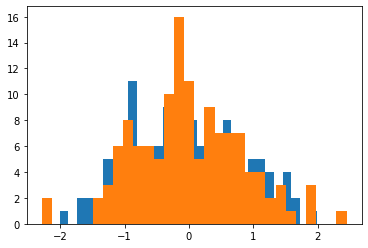

In [64]:
plt.hist(latent_2.numpy(), bins=30)
plt.hist(latent_code, bins=30)
plt.show()

In [65]:
results_dict_path = os.path.join(os.path.dirname(results.__file__), 'runs', folder, 'results.npy')
results_dict = np.load(results_dict_path, allow_pickle=True).item()
latent_1 = torch.from_numpy(results_dict['train']['latent_codes'][-1][0])
latent_2 = torch.from_numpy(results_dict['train']['latent_codes'][-1][1])
latent_3 = torch.from_numpy(results_dict['train']['latent_codes'][-1][2])

In [66]:
latent_1

tensor([ 1.3477, -0.7130,  0.1493, -0.9037,  0.2188,  0.3179, -0.5691,  1.3746,
         0.4855, -0.0708, -0.2439,  0.0207, -1.2790, -1.3142, -0.0133,  0.4331,
        -2.2047, -0.0764,  0.0808,  1.3932, -0.3508, -0.1643, -0.1656, -0.6844,
         0.5744, -0.6373,  1.5346,  1.7136, -0.1886,  0.6647,  0.2456, -1.4714,
        -1.1432,  0.6323, -1.3200,  0.5659,  0.2085,  0.5544, -2.3658,  0.7660,
        -1.6305,  1.1720, -2.7591,  0.2554, -0.6820, -0.6887, -0.2294,  1.0355,
         0.1079,  0.3508, -0.2428,  0.4429, -0.3595,  0.4200, -0.4325, -0.3206,
         0.3115, -1.7546, -0.2702,  0.3325,  0.3804, -0.7941,  0.3755,  0.4757,
         2.0113, -1.0050,  1.0772, -0.2371,  0.8402,  0.8154,  2.1082,  0.1503,
         0.2041,  0.7379,  0.5435,  1.2553,  0.0625,  0.7034,  1.6001, -1.0535,
        -1.1991, -0.5381, -0.6923,  0.2105,  0.3835, -0.1289,  1.0505,  1.1412,
         1.6938, -0.2094, -0.0769,  0.8913, -0.2568,  1.5646,  1.0265,  0.1787,
         0.9897,  0.2673,  0.9387, -0.53